# Nipype Concepts: Interfaces

![](http://nipy.sourceforge.net/nipype/_static/nipype-banner-bg.png)

The goal of this notebook is to introduce and illustrate the basic concepts underlying Interfaces. Interfaces provide a unified Pythonic representation of modular analysis routines from various packages (e.g. FSL, SPM, Freesurfer, etc.). Interfaces know what sort of options an external program has and how to execute it. 

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#### Example: FSL BET

FSL's BET (or Brain Extraction Tool) rapidly skull-strips an image and optionally can save a binary brain mask file.

Let's take a look at our T1 image. First, let's define a quick helper function so we can see what our processing is doing.

In [2]:
def plot_slice(fname, z_idx=5):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.affine

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, int(ctr[2]) + z_idx]), 
               cmap="gray", vmin=vmin, vmax=vmax)
    plt.gca().set_axis_off()

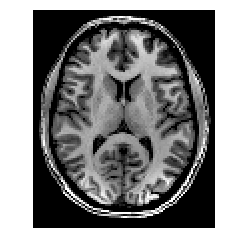

In [3]:
plot_slice("data/T1.nii.gz")

In its simplest form, just pass BET an input image and tell it what to name the output.

In [4]:
!bet data/T1.nii.gz data/T1_bet.nii.gz

Note that, in IPython, prepending a line with a bang (``!``) will make a shell call. This is a trick that is specific to IPython, although there are a variety of ways to execute system calls in Python that are slightly more verbose.

Let's take a look at the results:

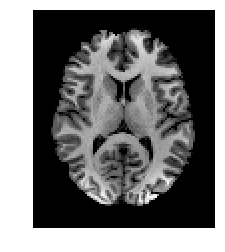

In [5]:
plot_slice("data/T1_bet.nii.gz")

What else can BET do? It's actually a fairly complicated program. As is the case for all FSL binaries, just call it with no arguments to see its options.

In [6]:
!bet


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

We see that BET can also return a binary brain mask as a result of the skull-strip, which can be useful for masking our GLM analyses (among other things). Let's run again including that option and see the result.

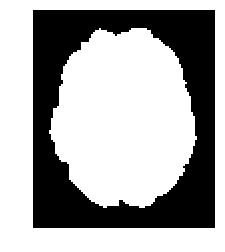

In [7]:
!bet data/T1 data/T1_bet -m
plot_slice("data/T1_bet_mask.nii.gz")

Now let's look at the BET interface in Nipype. First, we have to import it.

In [8]:
from nipype.interfaces.fsl import BET

Like all Python objects, some information can be found in what's called the docstring. In IPython, this is easy to display by postpending a ``?`` to the object's name. (This does the same thing as ``help object`` in MATLAB or ``?object`` in R). In the IPython notebook, that pops up a frame at the bottom of the screen, which we don't actually want right now. Let's get the docstring the longer way. It always lives at the ``__doc__`` attribute, so we can just print that. 

In [9]:
print(BET.__doc__)

Use FSL BET command for skull stripping.

    For complete details, see the `BET Documentation.
    <http://www.fmrib.ox.ac.uk/fsl/bet2/index.html>`_

    Examples
    --------
    >>> from nipype.interfaces import fsl
    >>> from nipype.testing import  example_data
    >>> btr = fsl.BET()
    >>> btr.inputs.in_file = example_data('structural.nii')
    >>> btr.inputs.frac = 0.7
    >>> res = btr.run() # doctest: +SKIP

    


Nipype also has a more comprehensive automatically generated help system built into its interfaces. To see that, just call the ``help`` method on any interface object:

In [10]:
print(BET.help())

Wraps command **bet**

Use FSL BET command for skull stripping.

For complete details, see the `BET Documentation.
<http://www.fmrib.ox.ac.uk/fsl/bet2/index.html>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import  example_data
>>> btr = fsl.BET()
>>> btr.inputs.in_file = example_data('structural.nii')
>>> btr.inputs.frac = 0.7
>>> res = btr.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to skull strip
		flag: %s, position: 0

	[Optional]
	args: (a string)
		Additional parameters to the command
		flag: %s
	center: (a list of at most 3 items which are an integer (int or
		 long))
		center of gravity in voxels
		flag: -c %s
	environ: (a dictionary with keys which are a value of class 'str' and
		 with values which are a value of class 'str', nipype default value:
		 {})
		Environment variables
	frac: (a float)
		fractional intensity threshold
		flag: -f %.2f
	functional: (a boolean)
		apply to 4D fMRI d

You can see a few things here. First, Nipype knows about the various options in the BET help we saw above, and exposes them as ``inputs``. There are a few ways to set inputs, but the most obvious is to create an interface instance and set them via the ``inputs`` attribute.

In [11]:
skullstrip = BET()
skullstrip.inputs.in_file = "data/T1.nii.gz"
skullstrip.inputs.out_file = "data/T1_bet_nipype.nii.gz"

Another way to set inputs on an interface object is to use them as keyword arguments when you call the class constructor. Don't worry if you don't know what a "class constructor" is. Doing the following will give you the same result as the three lines above.

In [12]:
skullstrip = BET(in_file="data/T1.nii.gz", out_file="data/T1_bet_nipype.nii.gz")

Interfaces know how to execute the processing you have specified. For command line programs like BET, they can generate the command-line string. To see what that looks like, just print the ``cmdline`` attribute:

In [13]:
print(skullstrip.cmdline)

bet data/T1.nii.gz data/T1_bet_nipype.nii.gz


Notice how that gives the command line we used above. As you may have noticed, the various optional parameters to the command line program are named with single letter strings of dubious mnemonic value. Nipype tries to turn those into more useful names. For instance, to generate a brain mask, instead of using the ``-m`` switch, just set the ``mask`` input to ``True``.

In [14]:
skullstrip.inputs.mask = True
print(skullstrip.cmdline)

bet data/T1.nii.gz data/T1_bet_nipype.nii.gz -m


So far we've just created an object that describes some element of processing. To actually execute it, you can call the ``run`` method on that object. For FSL, Freesurfer, and other programs, this will just make a system call with the command line we see above. For MATLAB-based programs like SPM, it will actually generate a ``.m`` file and run a MATLAB process to execute it. All of that is handled in the background, though: interfaces provide an abstract representation of analysis steps.

In [15]:
skullstrip.run()

We can see that this produced a file much like the one above:

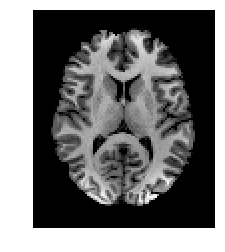

In [16]:
plot_slice("data/T1_bet_nipype.nii.gz")

Some interfaces cannot run without certain inputs being set. For instance, you need to give BET a file to work on. If you try and run it without setting the input file, you'll get a Python exception before anything actually gets executed:

In [17]:
skullstrip2 = BET()
skullstrip2.run()

ValueError: BET requires a value for input 'in_file'. For a list of required inputs, see BET.help()

Nipype also knows some things about what sort of values should get passed to the inputs, and will raise (hopefully) informative exceptions when they are violated -- before anything gets processed. For example, BET just lets you say "create a mask," it doesn't let you name it. You may forget this, and try to give it a name. In this case, Nipype will raise a ``TraitError`` telling you what you did wrong:

In [18]:
skullstrip.inputs.mask = "mask_file.nii"

TraitError: The 'mask' trait of a BETInputSpec instance must be a boolean, but a value of 'mask_file.nii' <class 'str'> was specified.

Additionally, Nipype knows that, for inputs corresponding to files you are going to process, they should exist in your filesystem. If you pass a string that doesn't correspond to an existing file, it will error and let you know:

In [19]:
skullstrip.inputs.in_file = "data/oops_a_typo.nii"

TraitError: The 'in_file' trait of a BETInputSpec instance must be an existing file name, but a value of 'data/oops_a_typo.nii' <class 'str'> was specified.

It turns out that for default output files, you don't even need to specify a name. Nipype will know what files are going to be created and will generate a name for you:

In [20]:
skullstrip = BET(in_file="data/T1.nii.gz")
print(skullstrip.cmdline)

bet data/T1.nii.gz ~/nipype_concepts/T1_brain.nii.gz


Note that it is going to write the output file to the local directory.

What if you just ran this interface and wanted to know what it called the file that was produced? As you might have noticed before, calling the ``run`` method returned an object called ``InterfaceResult.``  Let's inspect that object:

In [21]:
res = skullstrip.run()
print(res.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = <undefined>
meshfile = <undefined>
out_file = ~/nipype_concepts/T1_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



We see that four possible files can be generated by BET. Here we ran it in the most simple way possible, so it just generated an ``out_file``, which is the skull-stripped image. Let's see what happens when we generate a mask. By the way, you can also set inputs at runtime by including them as arguments to the ``run`` method:

In [22]:
res2 = skullstrip.run(mask=True)
print(res2.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = ~/nipype_concepts/T1_brain_mask.nii.gz
meshfile = <undefined>
out_file = ~/nipype_concepts/T1_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>



Nipype knows that if you ask for a mask, BET is going to generate it in a particular way and makes that information availbile to you.

A major motivating objective for Nipype is to streamline the integration of different analysis packages, so that you can use the algorithms you feel are best suited to your particular problem. Say that you want to use BET, as SPM does not offer a way to create an explicit mask from functional data, but that otherwise you want your processing to occur in SPM. Although possible to do this in a MATLAB script, it might not be all that clean, particularly if you want your skullstrip to happen in the middle of your workflow (for instance, after realignment). Nipype provides a unified representation of interfaces across analysis packages. To what we mean, let's look at SPM's Realign interface:

In [23]:
from nipype.interfaces.spm import Realign
print(Realign.help())

Use spm_realign for estimating within modality rigid body alignment

http://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=25

Examples
--------

>>> import nipype.interfaces.spm as spm
>>> realign = spm.Realign()
>>> realign.inputs.in_files = 'functional.nii'
>>> realign.inputs.register_to_mean = True
>>> realign.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_files: (a list of items which are a list of items which are an
		 existing file name or an existing file name)
		list of filenames to realign

	[Optional]
	fwhm: (a floating point number >= 0.0)
		gaussian smoothing kernel width
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	interp: (0 <= a long integer <= 7)
		degree of b-spline used for interpolation
	jobtype: ('estwrite' or 'estimate' or 'write', nipype default value:
		 estwrite)
		one of: estimate, write, estwrite
	matlab_cmd: (a string)
		matlab command to use
	mf

Setting inputs and running this interface looks exactly the same as it did for BET, even though Realign will run through MATLAB while BET is a command-line program coded in C++:

In [24]:
!gunzip -c data/timeseries.nii.gz > data/timeseries.nii  # SPM cannot read compressed files natively
realign = Realign(in_files="data/timeseries.nii")
realign.inputs.register_to_mean = False
realign.inputs.interp = 3
# realign.run()  # Uncomment if you have SPM installed and want it to run

What if you want to do some custom processing using the large (and growing) stack of scientific tools in Python itself? A special interface lets you wrap an arbitrary Python funtion. Here's a trivial example:

In [25]:
def add_two(x):
    return x + 2

In [26]:
from nipype import Function
addtwo = Function(input_names=["x"],
                  output_names=["val"],
                  function=add_two)

In [27]:
print(addtwo.run(x=4).outputs.val)

6


The <a href=http://nipy.sourceforge.net/nipype/users/function_interface.html>online docs</a> have a special section on the function interface with more examples and a few important points to keep in mind.

In [28]:
!make clean